# Module 1: News classification with topic models in gensim
### https://markroxor.github.io/gensim/static/notebooks/gensim_news_classification.html

News article classification is a task which is performed on a huge scale by news agencies all over the world. We will be looking into how topic modeling can be used to accurately classify news articles into different categories such as sports, technology, politics etc.

For this tutorial, we will be using the Lee corpus which is a shortened version of the Lee Background Corpus. The shortened version consists of 300 documents selected from the Australian Broadcasting Corporation's news mail service. It consists of texts of headline stories from around the year 2000-2001.

In this tutorial we look at how different topic models can be easily created using gensim.

We will be playing around with 4 different topic models here:

- LSI (Latent Semantic Indexing)
- HDP (Hierarchical Dirichlet Process)
- LDA (Latent Dirichlet Allocation)
- LDA (tweaked with topic coherence to find optimal number of topics) and
- LDA as LSI with the help of topic coherence metrics

First we'll fit those topic models on our existing data then we'll compare each against the other and see how they rank in terms of human interpretability.

All can be found in gensim and can be easily used in a plug-and-play fashion. 

In [17]:
import os
import re
import operator
import matplotlib.pyplot as plt
import warnings
import gensim
import numpy as np
warnings.filterwarnings('ignore')  # Let's not pay heed to them right now

from gensim.models import CoherenceModel, LdaModel, LsiModel, HdpModel
from gensim.models.wrappers import LdaMallet
from gensim.corpora import Dictionary
from pprint import pprint

%matplotlib inline

In [18]:
test_data_dir = '{}'.format(os.sep).join([gensim.__path__[0], 'test', 'test_data'])
lee_train_file = test_data_dir + os.sep + 'lee_background.cor'

Analysing our corpus.

- The first document talks about a bushfire that had occured in New South Wales.
- The second talks about conflict between India and Pakistan in Kashmir.
- The third talks about road accidents in the New South Wales area.
- The fourth one talks about Argentina's economic and political crisis during that time.
- The last one talks about the use of drugs by midwives in a Sydney hospital.
Our final topic model should be giving us keywords which we can easily interpret and make a small summary out of. Without this the topic model cannot be of much practical use.

In [52]:
with open(lee_train_file, 'r') as f:
    for n, l in enumerate(f):
        if n < 5:
            print([l])

['Hundreds of people have been forced to vacate their homes in the Southern Highlands of New South Wales as strong winds today pushed a huge bushfire towards the town of Hill Top. A new blaze near Goulburn, south-west of Sydney, has forced the closure of the Hume Highway. At about 4:00pm AEDT, a marked deterioration in the weather as a storm cell moved east across the Blue Mountains forced authorities to make a decision to evacuate people from homes in outlying streets at Hill Top in the New South Wales southern highlands. An estimated 500 residents have left their homes for nearby Mittagong. The New South Wales Rural Fire Service says the weather conditions which caused the fire to burn in a finger formation have now eased and about 60 fire units in and around Hill Top are optimistic of defending all properties. As more than 100 blazes burn on New Year\'s Eve in New South Wales, fire crews have been called to new fire at Gunning, south of Goulburn. While few details are available at t

In [72]:
def build_texts(fname):
    """
    Function to build tokenized texts from file
    
    Parameters:
    ----------
    fname: File to be read
    
    Returns:
    -------
    yields preprocessed line
    """
    with open(fname, 'r') as f:
        for line in f:
            yield gensim.utils.simple_preprocess(line, deacc=True, min_len=3)

In [162]:
train_texts = list(build_texts(lee_train_file))

In [146]:
len(train_texts)

300

### Preprocessing the Data 

- Stopword removal using NLTK's english stopwords dataset.
- Bigram collocation detection (frequently co-occuring tokens) using gensim's Phrases. This is our first attempt to find some hidden structure in the corpus. You can even try trigram collocation detection.
- Lemmatization (using gensim's lemmatize) to only keep the nouns. Lemmatization is generally better than stemming in the case of topic modeling since the words after lemmatization still remain understable. However, generally stemming might be preferred if the data is being fed into a vectorizer and isn't intended to be viewed.

In [86]:
bigram = gensim.models.Phrases(train_texts)  # for bigram collocation detection

In [87]:
bigram[['new', 'york', 'example']]

['new_york', 'example']

In [128]:
from gensim.utils import lemmatize
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

In [89]:
stops = set(stopwords.words('english'))

In [165]:
def process_texts(texts):
    """
    Function to process texts. Following are the steps we take:
    
    1. Stopword Removal.
    2. Collocation detection.
    3. Lemmatization (not stem since stemming can reduce the interpretability).
    
    Parameters:
    ----------
    texts: Tokenized texts.
    
    Returns:
    -------
    texts: Pre-processed tokenized texts.
    """
    texts = [[word for word in line if word not in stops] for line in texts]
    texts = [bigram[line] for line in texts]
    #lemmatizer = WordNetLemmatizer()
    #texts = [lemmatizer.lemmatize(word) for word in texts]
    # texts = [[word.split('/')[0] for word in lemmatize(' '.join(line), allowed_tags=re.compile('(NN)'), min_length=3)] for line in texts]
    return texts

# So we're setting the word limit in one go here.
# I skipped the lemmative part as I just couldn't get it working with the bytes strings issue

In [166]:
train_texts = process_texts(train_texts)
train_texts[5:6]

# Originally got error when I ran this due to Py3 encoding issue. 
# In Py3, the default string type is unicode. encode converts it to bytestring. 
# To apply strip to bytestring, you need to provide a matching character:

[['federal_government',
  'says',
  'safe',
  'afghani',
  'asylum_seekers',
  'australia',
  'return',
  'home',
  'environment',
  'becomes',
  'secure',
  'government',
  'suspended',
  'applications',
  'interim_government',
  'established',
  'kabul',
  'foreign_affairs',
  'minister_alexander',
  'downer',
  'refused',
  'say',
  'long',
  'claims',
  'process',
  'put',
  'hold',
  'says',
  'major',
  'threat',
  'people',
  'seeking',
  'asylum',
  'longer',
  'many',
  'afghans',
  'tried',
  'get',
  'australia',
  'matter',
  'britain',
  'countries',
  'north',
  'west',
  'europe',
  'claimed',
  'fleeing',
  'taliban',
  'said',
  'well',
  'taliban',
  'longer',
  'power',
  'afghanistan',
  'taliban',
  'finished',
  'meanwhile',
  'mass',
  'airlift',
  'detainees',
  'christmas',
  'island',
  'pacific',
  'island',
  'nauru',
  'total',
  'people',
  'flown',
  'island',
  'two',
  'operations',
  'using',
  'chartered',
  'aircraft',
  'second',
  'airlift',
  'tod

Finalising our dictionary and corpus

In [167]:
dictionary = Dictionary(train_texts)
corpus = [dictionary.doc2bow(text) for text in train_texts]

Topic modeling with LSI

This is a useful topic modeling algorithm in that it can rank topics by itself. Thus it outputs topics in a ranked order. However it does require a num_topics parameter (set to 200 by default) to determine the number of latent dimensions after the SVD.

In [168]:
lsimodel = LsiModel(corpus=corpus, num_topics=10, id2word=dictionary)
# Like LDA, it requires input of number of topics

In [169]:
lsimodel.show_topics(num_topics=5)  # Showing only the top 5 topics
# The results aren't as goos as if I had lemmatized, but still not bad. 

[(0,
  '0.542*"said" + 0.349*"says" + 0.127*"arafat" + 0.122*"palestinian" + 0.118*"people" + 0.117*"israeli" + 0.112*"two" + 0.110*"australian" + 0.110*"also" + 0.107*"australia"'),
 (1,
  '-0.407*"says" + 0.321*"arafat" + 0.315*"palestinian" + 0.273*"israeli" + 0.192*"israel" + 0.173*"sharon" + -0.145*"australia" + -0.143*"australian" + 0.140*"west_bank" + 0.136*"hamas"'),
 (2,
  '-0.349*"says" + 0.330*"said" + 0.202*"afghanistan" + 0.191*"bin_laden" + 0.178*"taliban" + 0.169*"pakistan" + -0.161*"australia" + -0.149*"arafat" + 0.126*"tora_bora" + -0.124*"israeli"'),
 (3,
  '0.292*"fire" + 0.240*"sydney" + -0.215*"says" + 0.184*"firefighters" + 0.171*"south" + 0.164*"wales" + 0.164*"new_south" + 0.163*"north" + 0.161*"fires" + -0.151*"afghanistan"'),
 (4,
  '-0.220*"said" + -0.171*"match" + -0.171*"test" + 0.154*"afghanistan" + 0.150*"government" + 0.148*"says" + -0.144*"first" + 0.142*"fire" + -0.138*"australia" + 0.135*"force"')]

In [170]:
lsitopics = lsimodel.show_topics(formatted=False)

Topic modeling with HDP

An HDP model is fully unsupervised. It can also determine the ideal number of topics it needs through posterior inference. (So this is a big advantage)

In [171]:
hdpmodel = HdpModel(corpus=corpus, id2word=dictionary)

In [172]:
hdpmodel.show_topics()

[(0,
  '0.003*said + 0.003*israeli + 0.003*match + 0.002*says + 0.002*australia + 0.002*rafter + 0.002*human + 0.002*team + 0.002*research + 0.001*hamas + 0.001*guarantee + 0.001*played + 0.001*launched + 0.001*france + 0.001*government + 0.001*tennis + 0.001*groups + 0.001*australian + 0.001*destroyer + 0.001*singles'),
 (1,
  '0.004*said + 0.003*palestinian + 0.002*government + 0.002*sharon + 0.002*called + 0.002*israeli + 0.002*suicide_attacks + 0.001*public + 0.001*group + 0.001*human_rights + 0.001*call + 0.001*arafat + 0.001*justice + 0.001*security + 0.001*israel + 0.001*terrorism + 0.001*owen + 0.001*armed + 0.001*statement + 0.001*gaza_strip'),
 (2,
  '0.006*said + 0.003*airport + 0.003*australia + 0.003*taliban + 0.002*kandahar + 0.002*killed + 0.002*half + 0.002*opposition + 0.002*day + 0.001*people + 0.001*gul + 0.001*civilians + 0.001*near + 0.001*left + 0.001*city + 0.001*conference + 0.001*says + 0.001*night + 0.001*agha + 0.001*wounded'),
 (3,
  '0.003*says + 0.003*team

In [173]:
hdptopics = hdpmodel.show_topics(formatted=False)

Topic modeling using LDA

This is one the most popular topic modeling algorithms today. It is a generative model in that it assumes each document is a mixture of topics and in turn, each topic is a mixture of words. To understand it better you can watch this lecture by David Blei. Let's choose 10 topics to initialize this.



In [175]:
ldamodel = LdaModel(corpus=corpus, num_topics=10, id2word=dictionary)

# I don't know if I have less data or what, but I'm used to this taking much longer with R topicmodeling

pyLDAvis is a great way to visualize an LDA model. To summarize in short, the area of the circles represent the prevelance of the topic. The length of the bars on the right represent the membership of a term in a particular topic.

In [177]:
import pyLDAvis.gensim

C:\Users\Christian Conroy\Anaconda3\lib\site-packages\past\types\oldstr.py:33: DeprecationWarning: invalid escape sequence \d
  """


In [178]:
pyLDAvis.enable_notebook()

In [179]:
pyLDAvis.gensim.prepare(ldamodel, corpus, dictionary)

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
1      0.019562  0.015357       1        1  14.527072
6      0.017841  0.004561       2        1  14.486258
4      0.029098 -0.003678       3        1  12.632985
3      0.048621 -0.034673       4        1  10.311128
8     -0.016091  0.003496       5        1   9.441516
2     -0.057796 -0.014850       6        1   9.233746
5     -0.001049  0.041732       7        1   9.198901
7     -0.015136  0.020960       8        1   8.858338
0     -0.003981  0.016198       9        1   7.461198
9     -0.021069 -0.049102      10        1   3.848854, topic_info=     Category        Freq          Term       Total  loglift  logprob
99    Default  332.000000          says  332.000000  30.0000  30.0000
2780  Default   30.000000        qantas   30.000000  29.0000  29.0000
986   Default  116.000000    australian  116.000000  28.0000  28.0000
98    Default  386.000000          said  386.000000  27.0000  27.0000
2738  Default   54.000000       company   54.000000  26.0000  26.0000
43    Default   49.000000          fire   49.000000  25.0000  25.0000
349   Default   64.000000   afghanistan   64.000000  24.0000  24.0000
967   Default   70.000000   palestinian   70.000000  23.0000  23.0000
565   Default   17.000000         river   17.000000  22.0000  22.0000
356   Default  118.000000     australia  118.000000  21.0000  21.0000
110   Default   46.000000        sydney   46.000000  20.0000  20.0000
1556  Default   26.000000        metres   26.000000  19.0000  19.0000
200   Default   98.000000           two   98.000000  18.0000  18.0000
258   Default   96.000000    government   96.000000  17.0000  17.0000
6364  Default    9.000000         virus    9.000000  16.0000  16.0000
4941  Default    7.000000       lockett    7.000000  15.0000  15.0000
1164  Default   28.000000       workers   28.000000  14.0000  14.0000
2716  Default   15.000000  hollingworth   15.000000  13.0000  13.0000
956   Default   69.000000       israeli   69.000000  12.0000  12.0000
80    Default   71.000000           new   71.000000  11.0000  11.0000
126   Default   37.000000          year   37.000000  10.0000  10.0000
1500  Default   33.000000        report   33.000000   9.0000   9.0000
125   Default   16.000000         winds   16.000000   8.0000   8.0000
738   Default   17.000000           cut   17.000000   7.0000   7.0000
44    Default   19.000000  firefighters   19.000000   6.0000   6.0000
3254  Default   18.000000   australians   18.000000   5.0000   5.0000
1075  Default   40.000000      per_cent   40.000000   4.0000   4.0000
150   Default   28.000000         india   28.000000   3.0000   3.0000
113   Default   64.000000         today   64.000000   2.0000   2.0000
2551  Default   58.000000        arafat   58.000000   1.0000   1.0000
...       ...         ...           ...         ...      ...      ...
655   Topic10    2.029723         asked   20.277527   0.9558  -6.4118
110   Topic10    3.224349        sydney   46.588448   0.5868  -5.9490
113   Topic10    3.797345         today   64.310043   0.4280  -5.7854
102   Topic10    2.766189         south   37.303616   0.6558  -6.1022
1385  Topic10    1.951229         court   20.904114   0.8859  -6.4513
4     Topic10    3.072718        around   50.777851   0.4525  -5.9972
1098  Topic10    1.730370      director   17.033756   0.9705  -6.5714
1926  Topic10    1.788546        damage   18.459715   0.9232  -6.5383
200   Topic10    4.102995           two   98.135078   0.0828  -5.7080
1476  Topic10    2.414115        centre   35.222977   0.5770  -6.2384
82    Topic10    2.297526         north   32.189941   0.6176  -6.2879
98    Topic10    7.523028          said  386.498230  -0.6818  -5.1017
245   Topic10    2.297060          days   32.698654   0.6017  -6.2881
99    Topic10    6.276029          says  332.745209  -0.7132  -5.2830
81    Topic10    2.248938     new_south   32.454315   0.5880  -6.3093
299   Topic10    2.

In [180]:
ldatopics = ldamodel.show_topics(formatted=False)

### ldatopics = ldamodel.show_topics(formatted=False)

Topic coherence in essence measures the human interpretability of a topic model. Traditionally perplexity has been used to evaluate topic models however this does not correlate with human annotations at times. Topic coherence is another way to evaluate topic models with a much higher guarantee on human interpretability. Thus this can be used to compare different topic models among many other use-cases.

In [181]:
def evaluate_graph(dictionary, corpus, texts, limit):
    """
    Function to display num_topics - LDA graph using c_v coherence
    
    Parameters:
    ----------
    dictionary : Gensim dictionary
    corpus : Gensim corpus
    limit : topic limit
    
    Returns:
    -------
    lm_list : List of LDA topic models
    c_v : Coherence values corresponding to the LDA model with respective number of topics
    """
    c_v = []
    lm_list = []
    for num_topics in range(1, limit):
        lm = LdaModel(corpus=corpus, num_topics=num_topics, id2word=dictionary)
        lm_list.append(lm)
        cm = CoherenceModel(model=lm, texts=texts, dictionary=dictionary, coherence='c_v')
        c_v.append(cm.get_coherence())
        
    # Show graph
    x = range(1, limit)
    plt.plot(x, c_v)
    plt.xlabel("num_topics")
    plt.ylabel("Coherence score")
    plt.legend(("c_v"), loc='best')
    plt.show()
    
    return lm_list, c_v

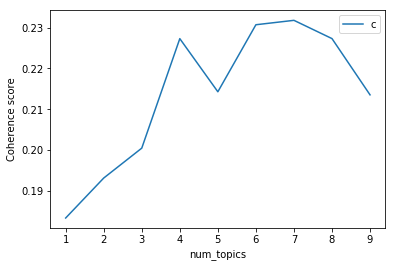

Wall time: 2min 16s


In [184]:
%%time
lmlist, c_v = evaluate_graph(dictionary=dictionary, corpus=corpus, texts=train_texts, limit=10)

# This time function is nifty!

In [188]:
pyLDAvis.gensim.prepare(lmlist[2], corpus, dictionary)
# For some reason it is not saving the lmlist object... 

NameError: name 'lmlist' is not defined

In [187]:
lmtopics = lmlist[5].show_topics(formatted=False)

NameError: name 'lmlist' is not defined

One of the problem with LDA is that if we train it on a large number of topics, the topics get "lost" among the numbers. Let us see if we can dig out the best topics from the best LDA model we can produce. The function below can be used to control the quality of the LDA model we produce.

In [189]:
def ret_top_model():
    """
    Since LDAmodel is a probabilistic model, it comes up different topics each time we run it. To control the
    quality of the topic model we produce, we can see what the interpretability of the best topic is and keep
    evaluating the topic model until this threshold is crossed. 
    
    Returns:
    -------
    lm: Final evaluated topic model
    top_topics: ranked topics in decreasing order. List of tuples
    """
    top_topics = [(0, 0)]
    while top_topics[0][1] < 0.97:
        lm = LdaModel(corpus=corpus, id2word=dictionary)
        coherence_values = {}
        for n, topic in lm.show_topics(num_topics=-1, formatted=False):
            topic = [word for word, _ in topic]
            cm = CoherenceModel(topics=[topic], texts=train_texts, dictionary=dictionary, window_size=10)
            coherence_values[n] = cm.get_coherence()
        top_topics = sorted(coherence_values.items(), key=operator.itemgetter(1), reverse=True)
    return lm, top_topics

In [190]:
lm, top_topics = ret_top_model()
# long running time. That's the LDA I know and love. 

KeyboardInterrupt: 

In [ ]:
print(top_topics[:5])

In [ ]:
pprint([lm.show_topic(topicid) for topicid, c_v in top_topics[:10]])

In [ ]:
lda_lsi_topics = [[word for word, prob in lm.show_topic(topicid)] for topicid, c_v in top_topics]

### Evaluating all the topic models
Any topic model which can come up with topic terms can be plugged into the coherence pipeline. You can even plug in an NMF topic model created with scikit-learn.

In [ ]:
lsitopics = [[word for word, prob in topic] for topicid, topic in lsitopics]

hdptopics = [[word for word, prob in topic] for topicid, topic in hdptopics]

ldatopics = [[word for word, prob in topic] for topicid, topic in ldatopics]

lmtopics = [[word for word, prob in topic] for topicid, topic in lmtopics]

In [ ]:
lsi_coherence = CoherenceModel(topics=lsitopics[:10], texts=train_texts, dictionary=dictionary, window_size=10).get_coherence()

hdp_coherence = CoherenceModel(topics=hdptopics[:10], texts=train_texts, dictionary=dictionary, window_size=10).get_coherence()

lda_coherence = CoherenceModel(topics=ldatopics, texts=train_texts, dictionary=dictionary, window_size=10).get_coherence()

lm_coherence = CoherenceModel(topics=lmtopics, texts=train_texts, dictionary=dictionary, window_size=10).get_coherence()

lda_lsi_coherence = CoherenceModel(topics=lda_lsi_topics[:10], texts=train_texts, dictionary=dictionary, window_size=10).get_coherence()

In [ ]:
def evaluate_bar_graph(coherences, indices):
    """
    Function to plot bar graph.
    
    coherences: list of coherence values
    indices: Indices to be used to mark bars. Length of this and coherences should be equal.
    """
    assert len(coherences) == len(indices)
    n = len(coherences)
    x = np.arange(n)
    plt.bar(x, coherences, width=0.2, tick_label=indices, align='center')
    plt.xlabel('Models')
    plt.ylabel('Coherence Value')

In [ ]:
evaluate_bar_graph([lsi_coherence, hdp_coherence, lda_coherence, lm_coherence, lda_lsi_coherence],
                   ['LSI', 'HDP', 'LDA', 'LDA_Mod', 'LDA_LSI'])

### Customizing the topic coherence measure¶
Till now we only used the c_v coherence measure. There are others such as u_mass, c_uci, c_npmi. All of these calculate coherence in a different way. c_v is found to be most in line with human ratings but can be much slower than u_mass since it uses a sliding window over the texts.

Making your own coherence measure
Let's modify c_uci to use s_one_pre instead of s_one_one segmentation

In [ ]:
from gensim.topic_coherence import (segmentation, probability_estimation,
                                    direct_confirmation_measure, indirect_confirmation_measure,
                                    aggregation)
from gensim.matutils import argsort
from collections import namedtuple

In [ ]:
make_pipeline = namedtuple('Coherence_Measure', 'seg, prob, conf, aggr')

In [ ]:
measure = make_pipeline(segmentation.s_one_one,
                        probability_estimation.p_boolean_sliding_window,
                        direct_confirmation_measure.log_ratio_measure,
                        aggregation.arithmetic_mean)

To get topics out of the topic model:

In [ ]:
topics = []
for topic in lm.state.get_lambda():
    bestn = argsort(topic, topn=10, reverse=True)
topics.append(bestn)

Step 1: Segmentation

In [ ]:
# Perform segmentation
segmented_topics = measure.seg(topics)

Step 2: Probability estimation

In [ ]:
# Since this is a window-based coherence measure we will perform window based prob estimation
per_topic_postings, num_windows = measure.prob(texts=train_texts, segmented_topics=segmented_topics,
                                               dictionary=dictionary, window_size=2)

Step 3: Confirmation Measure

In [ ]:
confirmed_measures = measure.conf(segmented_topics, per_topic_postings, num_windows, normalize=False)

Step 4: Aggregation

In [ ]:
print(measure.aggr(confirmed_measures))

### How this topic model can be used further
The best topic model here can be used as a standalone for news article classification. However a topic model can also be used as a dimensionality reduction algorithm to feed into a classifier. A good topic model should be able to extract the signal from the noise efficiently, hence improving the performance of the classifier.

# Module 2: Topic Modelling in Python with NLTK and Gensim
### https://towardsdatascience.com/topic-modelling-in-python-with-nltk-and-gensim-4ef03213cd21

In particular, we will cover Latent Dirichlet Allocation (LDA): a widely used topic modelling technique. And we will apply LDA to convert set of research papers to a set of topics.

Research paper topic modelling is an unsupervised machine learning method that helps us discover hidden semantic structures in a paper, that allows us to learn topic representations of papers in a corpus. The model can be applied to any kinds of labels on documents, such as tags on posts on the website.

### The Process
- We pick the number of topics ahead of time even if we’re not sure what the topics are.
- Each document is represented as a distribution over topics.
- Each topic is represented as a distribution over words.

### Text Cleaning
We use the following function to clean our texts and return a list of tokens:

In [198]:
# spaCy is a library for advanced Natural Language Processing in Python
import spacy
spacy.load('en')
from spacy.lang.en import English
parser = English()

def tokenize(text):
    lda_tokens = []
    tokens = parser(text)
    for token in tokens: # So this is taking each title I believe
        if token.orth_.isspace(): # orth: ID of the verbatim text content.
            continue
        elif token.like_url:
            lda_tokens.append('URL')
        elif token.orth_.startswith('@'):
            lda_tokens.append('SCREEN_NAME')
        else:
            lda_tokens.append(token.lower_)
    return lda_tokens

We use NLTK’s Wordnet to find the meanings of words, synonyms, antonyms, and more. In addition, we use WordNetLemmatizer to get the root word.

In [199]:
import nltk
nltk.download('wordnet')
from nltk.corpus import wordnet as wn
def get_lemma(word):
    lemma = wn.morphy(word)
    if lemma is None:
        return word
    else:
        return lemma
# Morphy uses a combination of inflectional ending rules and exception lists to handle a variety of different possibilities
# Morphy essentially helps in situations where the form in not in wordNet
from nltk.stem.wordnet import WordNetLemmatizer
def get_lemma2(word):
    return WordNetLemmatizer().lemmatize(word)

[nltk_data] Downloading package wordnet to C:\Users\Christian
[nltk_data]     Conroy\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


Filter out stop words:

In [200]:
nltk.download('stopwords')
en_stop = set(nltk.corpus.stopwords.words('english'))

[nltk_data] Downloading package stopwords to C:\Users\Christian
[nltk_data]     Conroy\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


Now we can define a function to prepare the text for topic modelling:

In [201]:
def prepare_text_for_lda(text):
    tokens = tokenize(text)
    tokens = [token for token in tokens if len(token) > 4] # Only 5 characters or more
    tokens = [token for token in tokens if token not in en_stop] # Take out stop words 
    tokens = [get_lemma(token) for token in tokens] #Lemmetize 
    return tokens

Open up our data, read line by line, for each line, prepare text for LDA, then add to a list.
Now we can see how our text data are converted:

In [203]:
import random
text_data = []
with open('dataset.csv') as f: # Downloaded from https://raw.githubusercontent.com/susanli2016/Machine-Learning-with-Python/master/dataset.csv
    for line in f:
        tokens = prepare_text_for_lda(line)
        if random.random() > .99:
            print(tokens)
            text_data.append(tokens)
            
# I think we're loading in only a small amount to make the tutorial easier. 

['social', 'status', 'analysis', 'palin', 'email', 'network']
['personalize', 'pocket', 'directory', 'mobile', 'devices']
['realistic', 'efficient', 'multi', 'channel', 'communications', 'wireless', 'sensor', 'network']
['frequency', 'response', 'masking', 'base', 'reconfigurable', 'channel', 'filter', 'software', 'radio', 'receiver']
['fusion', 'resolving', 'conflict', 'integration']
['designing', 'efficient', 'datapaths', 'compiler', 'exploration', 'methodology']
['scalable', 'query', 'services', 'fuzzy', 'ontology']
['interactive', 'texture', 'mapping']
['cognitive', 'mobile', 'virtual', 'network', 'operator', 'investment', 'pricing', 'supply', 'uncertainty']
['mining', 'frequent', 'close', 'cube', 'datasets']
['circuit', 'create', 'logarithmic', 'response', 'integrating', 'pixel']
['polymesh', 'level', 'algorithm']
['numerical', 'simulation', 'fluid', 'complex', 'geometry', 'using', 'lattice', 'boltzmann', 'method', 'enable']
['second', 'international', 'workshop', 'restful', 'desi

### LDA with Gensim
First, we are creating a dictionary from the data, then convert to bag-of-words corpus and save the dictionary and corpus for future use.

In [213]:
from gensim import corpora
dictionary = corpora.Dictionary(text_data) # Converting to corpora dictionary
corpus = [dictionary.doc2bow(text) for text in text_data] # Converting to bag of words 
import pickle # The whole annoying save thing as object thing in Python
pickle.dump(corpus, open('corpus.pkl', 'wb'))
dictionary.save('dictionary.gensim')

In [214]:
import gensim
NUM_TOPICS = 5
ldamodel = gensim.models.ldamodel.LdaModel(corpus, num_topics = NUM_TOPICS, id2word=dictionary, passes=15)
# An optimized implementation of the LDA algorithm, able to harness the power of multicore CPUs
ldamodel.save('model5.gensim')
topics = ldamodel.print_topics(num_words=4)
for topic in topics:
    print(topic)

(0, '0.030*"channel" + 0.030*"response" + 0.030*"base" + 0.030*"mobile"')
(1, '0.025*"algorithm" + 0.025*"network" + 0.025*"design" + 0.025*"goertzel"')
(2, '0.037*"power" + 0.037*"adaptive" + 0.020*"design" + 0.020*"using"')
(3, '0.035*"base" + 0.019*"output" + 0.019*"capacitance" + 0.019*"range"')
(4, '0.021*"minimal" + 0.021*"width" + 0.021*"dram" + 0.021*"email"')


With LDA, we can see that different document with different topics, and the discriminations are obvious.

Let’s try a new document:

In [215]:
# THIS IS ESSENTIALLY THE EQUIVALENT OF PREDICT FOR TOPIC MODELING LIKE THIS
new_doc = 'Practical Bayesian Optimization of Machine Learning Algorithms'
new_doc = prepare_text_for_lda(new_doc)
new_doc_bow = dictionary.doc2bow(new_doc)
print(new_doc_bow)
print(ldamodel.get_document_topics(new_doc_bow))

# Remember 0 indexing. Because Topic 1 dealt with algorithms and data sciency stuff, it makes sense this would be classified there. 

[(61, 1)]
[(0, 0.10002813), (1, 0.596633), (2, 0.1033012), (3, 0.100018084), (4, 0.10001958)]


My new document is about machine learning algorithms, the LDA out put shows that topic 1 has the highest probability assigned, and topic 3 has the second highest probability assigned. We agreed!

Now we are asking LDA to find 3 topics in the data:

In [216]:
ldamodel = gensim.models.ldamodel.LdaModel(corpus, num_topics = 3, id2word=dictionary, passes=15)
ldamodel.save('model3.gensim')
topics = ldamodel.print_topics(num_words=4)
for topic in topics:
    print(topic)

(0, '0.027*"adaptive" + 0.016*"base" + 0.016*"network" + 0.016*"using"')
(1, '0.023*"algorithm" + 0.023*"design" + 0.013*"base" + 0.013*"response"')
(2, '0.029*"power" + 0.028*"methodology" + 0.028*"devices" + 0.028*"mobile"')


We can also find 10 topics:

In [217]:
ldamodel = gensim.models.ldamodel.LdaModel(corpus, num_topics = 10, id2word=dictionary, passes=15)
ldamodel.save('model10.gensim')
topics = ldamodel.print_topics(num_words=4)
for topic in topics:
    print(topic)

(0, '0.028*"geometry" + 0.028*"fluid" + 0.028*"lattice" + 0.028*"numerical"')
(1, '0.043*"mapping" + 0.043*"texture" + 0.043*"interactive" + 0.043*"frequency"')
(2, '0.038*"mobile" + 0.038*"network" + 0.038*"operator" + 0.038*"cognitive"')
(3, '0.045*"base" + 0.024*"status" + 0.024*"capacitance" + 0.024*"capacitorless"')
(4, '0.008*"model" + 0.008*"equivalence" + 0.008*"design" + 0.008*"level"')
(5, '0.008*"base" + 0.008*"level" + 0.008*"equivalence" + 0.008*"algorithm"')
(6, '0.071*"adaptive" + 0.037*"using" + 0.037*"design" + 0.037*"motion"')
(7, '0.108*"power" + 0.038*"design" + 0.038*"devices" + 0.038*"methodology"')
(8, '0.056*"algorithm" + 0.056*"fusion" + 0.056*"conflict" + 0.056*"resolving"')
(9, '0.079*"efficient" + 0.041*"channel" + 0.041*"network" + 0.041*"realistic"')


pyLDAvis is designed to help users interpret the topics in a topic model that has been fit to a corpus of text data. The package extracts information from a fitted LDA topic model to inform an interactive web-based visualization.

Visualizing 5 topics:

In [218]:
dictionary = gensim.corpora.Dictionary.load('dictionary.gensim')
corpus = pickle.load(open('corpus.pkl', 'rb'))
lda = gensim.models.ldamodel.LdaModel.load('model5.gensim')
import pyLDAvis.gensim
lda_display = pyLDAvis.gensim.prepare(lda, corpus, dictionary, sort_topics=False)
pyLDAvis.display(lda_display)

- Saliency: a measure of how much the term tells you about the topic.
- Relevance: a weighted average of the probability of the word given the topic and the word given the topic normalized by the probability of the topic.
- The size of the bubble measures the importance of the topics, relative to the data.
- First, we got the most salient terms, means terms mostly tell us about what’s going on relative to the topics. We can also look at individual topic.

# Module 3: Topic Modeling Intro & Implementation
### https://www.kaggle.com/akashram/topic-modeling-intro-implementation

Popular topic modeling algorithms include Latent Semantic Analysis (LSA) a.k.a Latent Semantic Indexing , Hierarchical Dirichlet Process (HDP), Latent Dirichlet Allocation (LDA) and Non-negative Matrix factorization among which LDA has shown great results in practice and therefore widely adopted

- Latent Semantic Analysis
- Latent Dirichlet Allocation
- Hierarchical Dirichlet Process
- Non-negative Matrix factorization

Importing the important libraries and setting up the important libraries and cleaning datasets before we get into the methods

In [2]:
import os

import re
import numpy as np
import pandas as pd
from pprint import pprint
# The pprint module provides a capability to “pretty-print” arbitrary Python data structures in a form which can be used as input 
# to the interpreter. 

# Gensim
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel, LdaModel, LsiModel, HdpModel

# spacy for lemmatization
import spacy

# Plotting tools
import pyLDAvis
import pyLDAvis.gensim 
import matplotlib.pyplot as plt
%matplotlib inline

# Enable logging for gensim - optional
import logging
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.ERROR)

# Gensim uses Python’s standard logging module to log various stuff at various priority levels

import warnings
warnings.filterwarnings("ignore",category=DeprecationWarning)

Using the popular NLTK package in python, lets import the stopwords in the english language

In [3]:
# NLTK Stop words

from nltk.corpus import stopwords
stop_words = stopwords.words('english')
stop_words.extend(['from', 'subject', 're', 'edu', 'use','a','about', 'above', 'across'])
# We're adding a few on 

The extended stopwords list from the scikit learn library

In [4]:
st1= ['after', 'afterwards','again','against', 'all', 'almost','alone','along',
           'already',
           'also',
           'although',
           'always',
           'am',
           'among',
           'amongst',
           'amoungst',
           'amount',
           'an',
           'and',
           'another',
           'any',
           'anyhow',
           'anyone',
           'anything',
           'anyway',
           'anywhere',
           'are',
           'around',
           'as',
           'at',
           'back',
           'be',
           'became',
           'because',
           'become',
           'becomes',
           'becoming',
           'been',
           'before',
           'beforehand',
           'behind',
           'being',
           'below',
           'beside',
           'besides',
           'between',
           'beyond',
           'bill',
           'both',
           'bottom',
           'but',
           'by',
           'call',
           'can',
           'cannot',
           'cant',
           'co',
           'con',
           'could',
           'couldnt',
           'cry',
           'de',
           'describe',
           'detail',
           'do',
           'done',
           'down',
           'due',
           'during',
           'each',
           'eg',
           'eight',
           'either',
           'eleven',
           'else',
           'elsewhere',
           'empty',
           'enough',
           'etc',
           'even',
           'ever',
           'every',
           'everyone',
           'everything',
           'everywhere',
           'except',
           'few',
           'fifteen',
           'fifty',
           'fill',
           'find',
           'fire',
           'first',
           'five',
           'for',
           'former',
           'formerly',
           'forty',
           'found',
           'four',
           'from',
           'front',
           'full',
           'further',
           'get',
           'give',
           'go',
           'had',
           'has',
           'hasnt',
           'have',
           'he',
           'hence',
           'her',
           'here',
           'hereafter',
           'hereby',
           'herein',
           'hereupon',
           'hers',
           'herself',
           'him',
           'himself',
           'his',
           'how',
           'however',
           'hundred',
           'i',
           'ie',
           'if',
           'in',
           'inc',
           'indeed',
           'interest',
           'into',
           'is',
           'it',
           'its',
           'itself',
           'keep',
           'last',
           'latter',
           'latterly',
           'least',
           'less',
           'ltd',
           'made',
           'many',
           'may',
           'me',
           'meanwhile',
           'might',
           'mill',
           'mine',
           'more',
           'moreover',
           'most',
           'mostly',
           'move',
           'much',
           'must',
           'my',
           'myself',
           'name',
           'namely',
           'neither',
           'never',
           'nevertheless',
           'next',
           'nine',
           'no',
           'nobody',
           'none',
           'noone',
           'nor',
           'not',
           'nothing',
           'now',
           'nowhere',
           'of',
           'off',
           'often',
           'on',
           'once',
           'one',
           'only',
           'onto',
           'or',
           'other',
           'others',
           'otherwise',
           'our',
           'ours',
           'ourselves',
           'out',
           'over',
           'own',
           'part',
           'per',
           'perhaps',
           'please',
           'put',
           'rather',
           're',
           'same',
           'see',
           'seem',
           'seemed',
           'seeming',
           'seems',
           'serious',
           'several',
           'she',
           'should',
           'show',
           'side',
           'since',
           'sincere',
           'six',
           'sixty',
           'so',
           'some',
           'somehow',
           'someone',
           'something',
           'sometime',
           'sometimes',
           'somewhere',
           'still',
           'such',
           'system',
           'take',
           'ten',
           'than',
           'that',
           'the',
           'their',
           'them',
           'themselves',
           'then',
           'thence',
           'there',
           'thereafter',
           'thereby',
           'therefore',
           'therein',
           'thereupon',
           'these',
           'they',
           'thick',
           'thin',
           'third',
           'this',
           'those',
           'though',
           'three',
           'through',
           'throughout',
           'thru',
           'thus',
           'to',
           'together',
           'too',
           'top',
           'toward',
           'towards',
           'twelve',
           'twenty',
           'two',
           'un',
           'under',
           'until',
           'up',
           'upon',
           'us',
           'very',
           'via',
           'was',
           'we',
           'well',
           'were',
           'what',
           'whatever',
           'when',
           'whence',
           'whenever',
           'where',
           'whereafter',
           'whereas',
           'whereby',
           'wherein',
           'whereupon',
           'wherever',
           'whether',
           'which',
           'while',
           'whither',
           'who',
           'whoever',
           'whole',
           'whom',
           'whose',
           'why',
           'will',
           'with',
           'within',
           'without',
           'would',
           'yet',
           'you',
           'your',
           'yours',
           'yourself',
           'yourselves']

In [5]:
# More extension 
stop_words.extend(st1)

In [7]:
# Probably the easiest way to read in csv instead of the read/write way
data = pd.read_csv("uci-news-aggregator.csv")

Selecting sample rows from all categories(in this case, topics) so computations are quicker.

In [10]:
bg = data[data.CATEGORY == 'b']
tg = data[data.CATEGORY == 't']
eg = data[data.CATEGORY == 'e']
mg = data[data.CATEGORY == 'm']

In [11]:
bg_rows = np.random.choice(bg.index.values, 750)
bg_data = bg.ix[bg_rows]

tg_rows = np.random.choice(tg.index.values, 750)
tg_data = tg.ix[tg_rows]

eg_rows = np.random.choice(eg.index.values, 750)
eg_data = eg.ix[eg_rows]

mg_rows = np.random.choice(mg.index.values, 750)
mg_data = mg.ix[mg_rows]

# Randomly selecting systematically? 

In [12]:
data = bg_data.append([tg_data, eg_data, mg_data])

# So it's like getting a train but ensuring groups are represneted

In [13]:
title = data['TITLE']
category = data['CATEGORY']

### Latent Semantic Analysis

Latent Semantic Analysis (LSA) is a mathematical method that tries to bring out latent relationships within a collection of documents on to a lower dimensional space.LSA assumes that words that are close in meaning will occur in similar pieces of text (the distributional hypothesis). A matrix containing word counts per paragraph (rows represent unique words and columns represent each paragraph) is constructed from a large piece of text and a mathematical technique called singular value decomposition (SVD) is used to reduce the number of rows while preserving the similarity structure among columns. Rather than looking at each document isolated from the others it looks at all the documents as a whole and the terms within them to identify relationships.

For LSI, i'll be using scikit learn module

In [14]:
from sklearn.decomposition import NMF, LatentDirichletAllocation, TruncatedSVD
from sklearn.feature_extraction.text import CountVectorizer

# decomposition is for decomposing signals into components
# NMF: Find two non-negative matrices (W, H) whose product approximates the non- negative matrix X.
# Truncated SVD: Dimensionality reduction using truncated SVD (aka LSA).
    # This transformer performs linear dimensionality reduction by means of truncated singular value decomposition (SVD).
    # Contrary to PCA, this estimator does not center the data before computing the singular value decomposition. 
    # This means it can work with scipy.sparse matrices efficiently.
# CountVectorixer for your bag of words
 
NUM_TOPICS = 4 # Again have to lay it out manually here, but can optimize later

# Converting the document to a matrix of token counts

vectorizer = CountVectorizer(min_df=5, max_df=0.9, 
                             stop_words='english', lowercase=True, 
                             token_pattern='[a-zA-Z\-][a-zA-Z\-]{2,}')
data_vectorized = vectorizer.fit_transform(title)
 
# Build a Latent Semantic Indexing Model using SVD

lsi_model = TruncatedSVD(n_components=NUM_TOPICS)
lsi_Z = lsi_model.fit_transform(data_vectorized) # Again we first lay out the model and then we fit it
print(lsi_Z.shape)

(3000, 4)


In [15]:
lsi_model.components_

array([[ 0.01150109,  0.0013909 ,  0.00272349, ...,  0.08449477,
         0.0071406 ,  0.00107433],
       [-0.00301224,  0.00312257,  0.0181145 , ..., -0.02813827,
        -0.00076021,  0.00301811],
       [-0.00128584,  0.00360341, -0.00411213, ..., -0.01016361,
         0.00103708,  0.00286279],
       [-0.00061553,  0.01126786,  0.00529135, ..., -0.00510894,
         0.01406474,  0.00759107]])

In [16]:
def print_topics(model, vectorizer, top_n=10):
    for idx, topic in enumerate(model.components_): # Components is the probability for topics by word essentially I believe
        print("Topic %d:" % (idx))
        print([(vectorizer.get_feature_names()[i], topic[i])
                        for i in topic.argsort()[:-top_n - 1:-1]])
 
print("LSI Model:")
print_topics(lsi_model, vectorizer)
print("=" * 20)

# Remember will be 0-3 because of Python indexing

LSI Model:
Topic 0:
[('new', 0.9432185073432237), ('google', 0.14479494460518488), ('york', 0.08449476875086159), ('apple', 0.07930993518523458), ('says', 0.05970553453582807), ('android', 0.05902236568853411), ('cases', 0.05380102920117149), ('mers', 0.052913568873150706), ('study', 0.046817252582105374), ('facebook', 0.04166398358045328)]
Topic 1:
[('google', 0.8684237133519821), ('apple', 0.18454151595815158), ('glass', 0.17210658906820467), ('android', 0.15467681165819566), ('says', 0.11151973707356416), ('samsung', 0.08397937292657309), ('galaxy', 0.07507398466404752), ('search', 0.0698384508966611), ('health', 0.06404938829827467), ('day', 0.05101444517191157)]
Topic 2:
[('apple', 0.7721926180672215), ('samsung', 0.28966624291933646), ('galaxy', 0.21392330637585033), ('iphone', 0.16773899487291963), ('says', 0.16513909975126517), ('ipad', 0.14266905785777748), ('report', 0.10322335984845848), ('ceo', 0.08260256982495146), ('price', 0.059433175259114554), ('ibm', 0.057426594263465

Now we get to visualizing 

In [17]:
from sklearn.manifold import TSNE # Manifold learning is an approach to non-linear dimensionality reduction. Algorithms for this task 
# are based on the idea that the dimensionality of many data sets is only artificially high.
# -SNE (TSNE) converts affinities of data points to probabilities. The affinities in the original space are represented by Gaussian 
# joint probabilities and the affinities in the embedded space are represented by Student’s t-distributions.

# NLTK
from nltk.tokenize import RegexpTokenizer # A ``RegexpTokenizer`` splits a string into substrings using a regular expression.
from nltk.stem.snowball import SnowballStemmer # Stemmers remove morphological affixes from words, leaving only the word stem.
from nltk.corpus import stopwords
import re # This module provides regular expression matching operations similar to those found in Perl.

# Visualization
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches # A patch is a 2D artist with a face color and an edge color.
import matplotlib
%matplotlib inline
import seaborn as sns

# Bokeh - Bokeh is an interactive visualization library that targets modern web browsers for presentation.
from bokeh.io import output_notebook
from bokeh.plotting import figure, show
from bokeh.models import HoverTool, CustomJS, ColumnDataSource, Slider
from bokeh.layouts import column
from bokeh.palettes import all_palettes
output_notebook()

Loading BokehJS ...

Lets now visualise the LSI model and see the words and documents that are close to each other according to the model

In [18]:
import pandas as pd
from bokeh.io import push_notebook, show, output_notebook
from bokeh.plotting import figure
from bokeh.models import ColumnDataSource, LabelSet
output_notebook()

svd = TruncatedSVD(n_components=100)
documents_2d = svd.fit_transform(data_vectorized)
 
df = pd.DataFrame(columns=['x', 'y', 'document'])
df['x'], df['y'], df['document'] = documents_2d[:,0], documents_2d[:,1], range(len(data))
 
source = ColumnDataSource(ColumnDataSource.from_df(df))
labels = LabelSet(x="x", y="y", text="document", y_offset=8,
                  text_font_size="8pt", text_color="#555555",
                  source=source, text_align='center')
 
plot = figure(plot_width=600, plot_height=600)
plot.circle("x", "y", size=12, source=source, line_color="black", fill_alpha=0.8)
plot.add_layout(labels)
show(plot, notebook_handle=True)


Loading BokehJS ...

The Inference from the plot above is that similar documents are plotted close by in a low dimensional space. Same with words(although not the objective here) shown below,

In [19]:
svd = TruncatedSVD(n_components=100)
words_2d = svd.fit_transform(data_vectorized.T)
 
df = pd.DataFrame(columns=['x', 'y', 'word']) # We don't have to create new word vector. It comes from what we already have.
df['x'], df['y'], df['word'] = words_2d[:,0], words_2d[:,1], vectorizer.get_feature_names()
 
source = ColumnDataSource(ColumnDataSource.from_df(df))
labels = LabelSet(x="x", y="y", text="word", y_offset=8,
                  text_font_size="8pt", text_color="#555555",
                  source=source, text_align='center')
 
plot = figure(plot_width=600, plot_height=600)
plot.circle("x", "y", size=12, source=source, line_color="black", fill_alpha=0.8)
plot.add_layout(labels)
show(plot, notebook_handle=True)

However, LSI has one major weakness – ambiguity. For example, how could a system determine if you are talking about Microsoft office, or the office in which you work. This is where LDA comes in, lets look at that.

## LDA


Is a generative statistical model that allows sets of observations to be explained by unobserved groups that explain why some parts of the data are similar. For example, if observations are words collected into documents, it posits that each document is a mixture of a small number of topics and that each word's presence is attributable to one of the document's topics. Because the structure is hidden (also known as latent), this method seeks to infer the topic structure given the known words and documents.

- Decide on the number of words N the document will have.
- Choose a topic mixture for the document (according to a Dirichlet probability distribution over a fixed set of K topics).
- Generate each word in the document by:
    - First picking a topic.
    - Then using the topic to generate the word itself (according to the topic’s multinomial distribution).
    - Assuming this generative model for a collection of documents, LDA then tries to backtrack from the documents to find a set of topics that are likely to have generated the collection.

Convert to list so we can do some pre-processing

In [33]:
# Convert to list
df = data.TITLE.values.tolist() # We have a column for title, so we convert that column into a list

df = [re.sub('\S*@\S*\s?', '', sent) for sent in df]

# Remove new line characters
df = [re.sub('\s+', ' ', sent) for sent in df]

# Remove distracting single quotes
df = [re.sub("\'", "", sent) for sent in df]

pprint(df[:1])

['Poll: Target shoppers mostly stick with chain after data breach']


In [34]:
df = [re.sub("-", " ", sent) for sent in df]
df = [re.sub(":", "", sent) for sent in df] # Get rid of those specific punctuations, which are in here a lot. 

All punctuations need to be removed, so lets write a function for that and we'll use the gensim package for that. deacc=TRUE does that

In [35]:
def sent_to_words(sentences):
    for sentence in sentences:
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))

df_words = list(sent_to_words(df))

Bigrams are two words frequently occurring together in the document. Trigrams are 3 words frequently occurring. Gensim's Phrases method helps us with that. (THIS IS BIG HELPS WITH THE GOOD NOT GOOD ISSUE)

In [36]:
# Build the bigram and trigram models

bigram = gensim.models.Phrases(df_words, min_count=5, threshold=100) # higher threshold fewer phrases.
trigram = gensim.models.Phrases(bigram[df_words], threshold=100)  

# Faster way to get a sentence clubbed as a trigram/bigram

bigram_mod = gensim.models.phrases.Phraser(bigram)
trigram_mod = gensim.models.phrases.Phraser(trigram)

We need to apply the bigrams, trigrams and lemmatize the set of documents we are working with.

In [37]:
def remove_stopwords(texts):
    return [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts] # Note brackets for double 
# nesting (word in doc in texts)

def make_bigrams(texts):
    return [bigram_mod[doc] for doc in texts] # Note we do this for doc not word level

def make_trigrams(texts):
    return [trigram_mod[bigram_mod[doc]] for doc in texts]

def lemmatization(texts, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
    texts_out = []
    for sent in texts:
        doc = nlp(" ".join(sent)) 
        texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_postags]) # Note for doc not word
    return texts_out

Applying the custom functions to our dataset

In [38]:
# Remove Stop Words

data_words_nostops = remove_stopwords(df_words)

# Form Bigrams

data_words_bigrams = make_bigrams(data_words_nostops)

nlp = spacy.load('en', disable=['parser', 'ner'])

data_lemmatized = lemmatization(data_words_bigrams, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV'])

As we saw in the definition above, converting our document set into a document-term matrix

In [39]:
# Create Dictionary
id2word = corpora.Dictionary(data_lemmatized)

# Create Corpus
texts = data_lemmatized

# Term Document Frequency
corpus = [id2word.doc2bow(text) for text in texts] # Bag of Words

Readable format of corpus (term-frequency)

In [42]:
[[(id2word[id], freq) for id, freq in cp] for cp in corpus[11:12]]

[[('profit', 1),
  ('crumb', 1),
  ('investing', 1),
  ('lemoni', 1),
  ('marcus', 1),
  ('star', 1)]]

Building the LDA model

In [43]:
lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=5, 
                                           random_state=100,
                                           update_every=1,
                                           chunksize=100,
                                           passes=10,
                                           alpha='auto',
                                           per_word_topics=True)
# Note the need for a corpus and dictionary for LDA model 

Now that the model is built, lets print the Keyword in the 10 topics

In [44]:
pprint(lda_model.print_topics())
doc_lda = lda_model[corpus]

[(0,
  '0.024*"say" + 0.014*"spread" + 0.014*"fda" + 0.012*"people" + 0.010*"help" '
  '+ 0.010*"make" + 0.009*"county" + 0.008*"low" + 0.008*"ebola_outbreak" + '
  '0.008*"treatment"'),
 (1,
  '0.030*"study" + 0.021*"heart" + 0.020*"virus" + 0.014*"not" + '
  '0.013*"recall" + 0.012*"age" + 0.010*"cigarette" + 0.009*"reveal" + '
  '0.009*"do" + 0.009*"high"'),
 (2,
  '0.033*"health" + 0.023*"mer" + 0.022*"cancer" + 0.017*"drug" + 0.016*"link" '
  '+ 0.010*"kid" + 0.009*"life" + 0.009*"disease" + 0.009*"drink" + '
  '0.008*"autism"'),
 (3,
  '0.027*"report" + 0.013*"blood" + 0.011*"hospital" + 0.011*"patient" + '
  '0.008*"old" + 0.008*"researcher" + 0.008*"urge" + 0.007*"bear" + '
  '0.007*"scientist" + 0.007*"guinea"'),
 (4,
  '0.036*"new" + 0.024*"risk" + 0.018*"death" + 0.018*"case" + 0.013*"woman" + '
  '0.013*"year" + 0.010*"alzheimer" + 0.010*"rate" + 0.008*"rise" + '
  '0.008*"official"')]


#### Right, now that the LDA model is built, there has to be a metric to evaluate how good the model is. Lets compute that to check how good it is.¶
There are 2 such metrics.
- 1) Perplexity - Is a statistical measure of how well a probability model predicts a sample. As applied to LDA, for a given value of k, you estimate the LDA model. Then given the theoretical word distributions represented by the topics, compare that to the actual topic mixtures, or distribution of words in your documents. - Lower the better.
- 2) Coherence Score - Is defined as the average / median of the pairwise word-similarity scores of the words in the topic - Higher the better.

In [45]:
# Compute Perplexity

print('\nPerplexity: ', lda_model.log_perplexity(corpus)) 

# Compute Coherence Score

coherence_model_lda = CoherenceModel(model=lda_model, texts=data_lemmatized, dictionary=id2word, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda)

# Perplexity makes it look good but I'm not sure what lower bound is. Assuming 0-1, coherence looks only OK. 


Perplexity:  -9.288459914450256

Coherence Score:  0.6598645875876011


From the model we created, lets look at the most salient terms under each topic that contributes to it the most

Now that we saw the coherence value for 5 topics, lets create a function to get the coherence values for the count of topics < 5

In [46]:
def compute_coherence_values(dictionary, corpus, texts, limit, start=2, step=3):
    coherence_values = []
    model_list = [] # We lay out what will go in our X and Y here
    for num_topics in range(start, limit, step):
        model = LdaModel(corpus=corpus, num_topics=num_topics, id2word=id2word)
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())

    return model_list, coherence_values

In [47]:
model_list, coherence_values = compute_coherence_values(dictionary=id2word, corpus=corpus, texts=data_lemmatized, start=1, limit=6, step=1)
# So when something outputs two things, can structure it like this to capture the objects

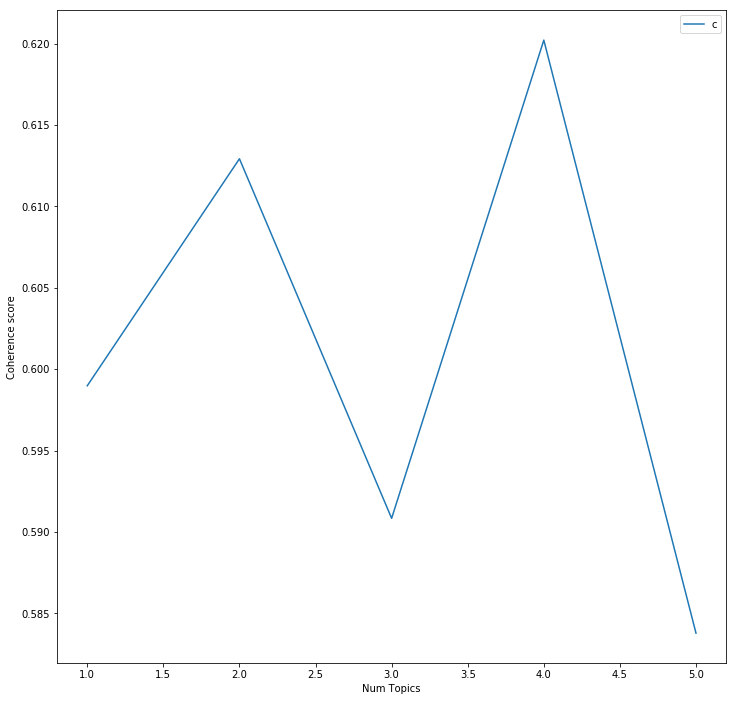

In [48]:
limit=6; start=1; step=1;
x = range(start, limit, step)
plt.figure(figsize=(12,12))
plt.plot(x, coherence_values)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()

# So we want high coherence, so 4 (what we used) looks best

In [49]:
# Get the actual values
for m, cv in zip(x, coherence_values):
    print("Num Topics =", m, " has Coherence Value of", round(cv, 4))

Num Topics = 1  has Coherence Value of 0.599
Num Topics = 2  has Coherence Value of 0.6129
Num Topics = 3  has Coherence Value of 0.5908
Num Topics = 4  has Coherence Value of 0.6202
Num Topics = 5  has Coherence Value of 0.5838


In [50]:
# Select the model and print the topics

optimal_model = model_list[3] # Because indexing
model_topics = optimal_model.show_topics(formatted=False)
pprint(optimal_model.print_topics(num_words=10))

[(0,
  '0.017*"health" + 0.012*"cancer" + 0.011*"risk" + 0.010*"new" + 0.007*"say" '
  '+ 0.007*"woman" + 0.007*"patient" + 0.006*"blood" + 0.006*"cigarette" + '
  '0.005*"recall"'),
 (1,
  '0.009*"heart" + 0.008*"study" + 0.006*"hospital" + 0.006*"link" + '
  '0.006*"make" + 0.005*"not" + 0.005*"people" + 0.005*"treatment" + '
  '0.004*"risk" + 0.004*"report"'),
 (2,
  '0.013*"new" + 0.008*"report" + 0.007*"death" + 0.006*"mer" + 0.006*"case" + '
  '0.004*"not" + 0.004*"man" + 0.004*"official" + 0.003*"release" + '
  '0.003*"know"'),
 (3,
  '0.012*"virus" + 0.008*"drug" + 0.006*"study" + 0.005*"new" + 0.005*"kid" + '
  '0.005*"report" + 0.005*"recall" + 0.005*"say" + 0.004*"young" + '
  '0.004*"spread"')]


The purpose of LDA is also to compute how much of the document was generated by which topic. Lets look at that.

In [51]:
def format_topics_sentences(ldamodel=lda_model, corpus=corpus, texts=data):
   
    sent_topics_df = pd.DataFrame()

   # A lot of times when dealing with iterators, we also get a need to keep a count of iterations. 
#Python eases the programmers’ task by providing a built-in function enumerate() for this task.

    for i, row in enumerate(ldamodel[corpus]):
        row = sorted(row, key=lambda x: (x[1]), reverse=True)
        # Get the Dominant topic, Perc Contribution and Keywords for each document
        for j, (topic_num, prop_topic) in enumerate(row):
            if j == 0:  # -- dominant topic
                wp = ldamodel.show_topic(topic_num)
                topic_keywords = ", ".join([word for word, prop in wp]) # Laying out the formmate for laying out topic words
                sent_topics_df = sent_topics_df.append(pd.Series([int(topic_num), round(prop_topic,4), topic_keywords]), ignore_index=True)
            else:
                break
    sent_topics_df.columns = ['Dominant_Topic', 'Perc_Contribution', 'Topic_Keywords']

    # Add original text to the end of the output
    
    contents = pd.Series(texts)
    sent_topics_df = pd.concat([sent_topics_df, contents], axis=1)
    return(sent_topics_df)
    

df_topic_sents_keywords = format_topics_sentences(ldamodel=optimal_model, corpus=corpus, texts=df)


df_dominant_topic = df_topic_sents_keywords.reset_index()
df_dominant_topic.columns = ['Document_No', 'Dominant_Topic', 'Topic_Perc_Contrib', 'Keywords', 'Text']


df_dominant_topic.head(5)

,Document_No,Dominant_Topic,Topic_Perc_Contrib,Keywords,Text
0,0,3.0,0.9009,"virus, drug, study, new, kid, report, recall, ...",Poll Target shoppers mostly stick with chain a...
1,1,3.0,0.9108,"virus, drug, study, new, kid, report, recall, ...",Tax Return Preparers Exemplify a Gaping Hole i...
2,2,2.0,0.8874,"new, report, death, mer, case, not, man, offic...",Priceline (PCLN) Agrees to Buy OpenTable Inc (...
3,3,0.0,0.9357,"health, cancer, risk, new, say, woman, patient...",Quartz Daily Brief—Americas edition—China Russ...
4,4,0.0,0.8408,"health, cancer, risk, new, say, woman, patient...",Will This Downgrade Hurt Alcoa (AA) Stock?


## Hierarchical Dirichlet Process


is a nonparametric Bayesian approach to clustering grouped data. It uses a Dirichlet process for each group of data, with the Dirichlet processes for all groups sharing a base distribution which is itself drawn from a Dirichlet process



This technique is not really suitable to a dataset or a problem where the number of topics is predetermined & thats where the difference lies between HDP and LDA

This technique is not really suitable to a dataset or a problem where the number of topics is predetermined & thats where the difference lies between HDP and LDA

In [52]:
from gensim.models import CoherenceModel, HdpModel

In [53]:
hdpmodel = HdpModel(corpus=corpus, id2word=id2word) # Already have from earlier 
# Same set up / pre processing as LDA

In [54]:
hdptopics = hdpmodel.show_topics(formatted=False)

In [55]:
hdptopics[0]

(0,
 [('teva', 0.0021849210458260602),
  ('government', 0.001958904184767307),
  ('patterson', 0.0016638799549224688),
  ('siemen', 0.0016586043390515092),
  ('enhancement', 0.0013649336082118108),
  ('run', 0.0013308148075149324),
  ('jame', 0.001264780464057406),
  ('update', 0.0012297746574657154),
  ('penis', 0.0012244672992310155),
  ('phusion', 0.001218119685025349),
  ('box', 0.001215578329374755),
  ('morcellator', 0.0012119006504856386),
  ('dementia', 0.0012065006057109186),
  ('people', 0.0011643766374705969),
  ('bacteria', 0.0011300415447316962),
  ('higher', 0.0011164210006914662),
  ('pencil', 0.0011068340047388108),
  ('spec', 0.0010933696706504604),
  ('peace', 0.0010873289167111027),
  ('cabo', 0.0010862673993637898)])

In [56]:
len(hdptopics)

20

The topics generated by HDP are as above. Lets look at the terms of the 1st topic. We also see that the model has generated 20 topics. We'll be comparing the coherence scores of the other models later, But before that, lets look at the next technique under topic modeling

## Non-Negative Matrix Factorization

Is a group of algorithms where a matrix V is factorized into (usually) two matrices W and H, with the property that all three matrices have no negative elements. This non-negativity makes the resulting matrices easier to inspect.

Latent Dirichlet Allocation (where documents are represented by latent topics, and topics are represented by a distribution over words) Non-negative Matrix Factorization (where a document-term matrix is approximately factorized into term-feature and feature-document matrices).

In [57]:
# Forming the matrix, getting the features and normalizing them
from nltk.corpus import stopwords;
import nltk;
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer;
from sklearn.decomposition import NMF;
from sklearn.preprocessing import normalize;

vectorizer = CountVectorizer(analyzer='word', max_features=5000, stop_words='english', lowercase=True, 
                             token_pattern='[a-zA-Z\-][a-zA-Z\-]{2,}');
x_counts = vectorizer.fit_transform(title);
print( "Created %d X %d document-term matrix" % (x_counts.shape[0], x_counts.shape[1]) ) # The technical unique nnmf part
transformer = TfidfTransformer(smooth_idf=False);
x_tfidf = transformer.fit_transform(x_counts);

Created 3000 X 5000 document-term matrix


In [58]:
terms = vectorizer.get_feature_names()
print("Vocabulary has %d distinct terms" % len(terms))

Vocabulary has 5000 distinct terms


In [59]:
xtfidf_norm = normalize(x_tfidf, norm='l1', axis=1)
model = NMF(n_components=5, init='nndsvd'); # Here we do identify num of topics, but like LDA we can kind of plot to get later
model.fit(xtfidf_norm)

NMF(alpha=0.0, beta_loss='frobenius', init='nndsvd', l1_ratio=0.0,
  max_iter=200, n_components=5, random_state=None, shuffle=False,
  solver='cd', tol=0.0001, verbose=0)

In order to get the topics, we'll again be creating a function. The NMF doesn't have the show topics method and hence we'll be taking the custom approach

In [61]:
def get_nmf_topics(model, n_top_words):
    
    feat_names = vectorizer.get_feature_names()
    
    word_dict = {};
    for i in range(num_topics):
        
        words_ids = model.components_[i].argsort()[:-20 - 1:-1]
        words = [feat_names[key] for key in words_ids]
        word_dict['Topic # ' + '{:02d}'.format(i+1)] = words;
    
    return pd.DataFrame(word_dict);

# argsort: Perform an indirect sort along the given axis using the algorithm specified by the kind keyword. 
# It returns an array of indices of the same shape as a that index data along the given axis in sorted order.

In [62]:
num_topics = 5
nmf_df = get_nmf_topics(model, 5)
nmf_df

,Topic # 01,Topic # 02,Topic # 03,Topic # 04,Topic # 05
0,new,google,samsung,ebola,study
1,amazon,glass,galaxy,virus,cancer
2,york,smartphone,apple,health,finds
3,game,amazon,ipad,mers,friends
4,phone,android,review,outbreak,risk
5,discovered,songza,microsoft,guinea,alzheimer
6,cases,acquires,office,west,facebook
7,planet,day,electronics,illinois,heart
8,just,partners,iphone,cases,linked
9,cities,twitch,guardians,spreads,autism


The table above shows the terms under each topic, as per the NMF model

In [63]:
raw_documents = title.str.strip()
raw_documents= raw_documents.str.lower()
raw_documents = raw_documents.tolist()
raw_doc1 = [i.split() for i in raw_documents]

In [64]:
from sklearn.feature_extraction.text import CountVectorizer
# use a custom stopwords list, set the minimum term-document frequency to 20
vectorizer = CountVectorizer(stop_words = stop_words, min_df = 20) #custom_stop_words
A = vectorizer.fit_transform(raw_documents)
print( "Created %d X %d document-term matrix" % (A.shape[0], A.shape[1]) ) # Shape gets at IDF I believe

Created 3000 X 103 document-term matrix


In [65]:
terms = vectorizer.get_feature_names()
print("Vocabulary has %d distinct terms" % len(terms))

Vocabulary has 103 distinct terms


In [66]:
from sklearn.feature_extraction.text import TfidfVectorizer
# we can pass in the same preprocessing parameters
vectorizer = TfidfVectorizer(stop_words= stop_words, min_df = 20) #custom_stop_words
A = vectorizer.fit_transform(raw_documents)
print( "Created %d X %d TF-IDF-normalized document-term matrix" % (A.shape[0], A.shape[1]) )

Created 3000 X 103 TF-IDF-normalized document-term matrix


Until now, we created the term matrix. lets rank the terms and build the model.

In [67]:
import operator
def rank_terms( A, terms ):
    # get the sums over each column
    sums = A.sum(axis=0)
    # map weights to the terms
    weights = {}
    for col, term in enumerate(terms):
        weights[term] = sums[0,col]
    # rank the terms by their weight over all documents
    return sorted(weights.items(), key=operator.itemgetter(1), reverse=True)

In [68]:
ranking = rank_terms( A, terms )
for i, pair in enumerate( ranking[0:20] ):
    print( "%02d. %s (%.2f)" % ( i+1, pair[0], pair[1] ) )

01. new (115.49)
02. google (71.30)
03. apple (51.96)
04. says (49.28)
05. study (47.52)
06. health (44.32)
07. facebook (43.23)
08. video (41.85)
09. ebola (41.56)
10. 2014 (38.73)
11. report (36.57)
12. cancer (34.97)
13. microsoft (34.58)
14. day (33.68)
15. year (32.48)
16. china (32.27)
17. review (31.07)
18. data (30.17)
19. sales (28.60)
20. samsung (28.50)


In [69]:
k = 10
# create the model
from sklearn import decomposition
model = decomposition.NMF( init="nndsvd", n_components=k ) 
# apply the model and extract the two factor matrices
W = model.fit_transform( A )
H = model.components_

Check Index for a Term

In [70]:
term_index = terms.index('samsung')
# round to 2 decimal places for display purposes
H[:,term_index].round(2)

array([0.  , 0.01, 0.  , 0.48, 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ])

Sorting the indexes we got using the model to plot and see the top terms.

In [71]:
import numpy as np
def get_descriptor( terms, H, topic_index, top ):
    # reverse sort the values to sort the indices
    top_indices = np.argsort( H[topic_index,:] )[::-1]
    # now get the terms corresponding to the top-ranked indices
    top_terms = []
    for term_index in top_indices[0:top]:
        top_terms.append( terms[term_index] )
    return top_terms

In [72]:
descriptors = []
for topic_index in range(k):
    descriptors.append( get_descriptor( terms, H, topic_index, 10 ) )
    str_descriptor = ", ".join( descriptors[topic_index] )
    print("Topic %02d: %s" % ( topic_index+1, str_descriptor ) )

Topic 01: new, cases, blood, mers, amazon, deal, gets, review, watch, android
Topic 02: google, glass, android, day, news, data, court, uk, time, amazon
Topic 03: study, finds, risk, cancer, heart, blood, linked, high, reveals, death
Topic 04: apple, samsung, iphone, galaxy, ipad, price, report, app, ceo, buy
Topic 05: health, report, heart, mers, world, life, cancer, year, gets, risk
Topic 06: says, report, china, fda, ceo, microsoft, world, review, change, tv
Topic 07: video, music, amazon, shows, watch, gm, game, ceo, set, time
Topic 08: facebook, twitter, app, report, global, shares, news, deal, company, data
Topic 09: ebola, outbreak, virus, west, death, cases, mers, uk, kanye, kardashian
Topic 10: 2014, day, year, time, report, movie, release, west, music, change


In [76]:
def plot_top_term_weights( terms, H, topic_index, top ): # H was the model components
    # get the top terms and their weights
    top_indices = np.argsort( H[topic_index,:] )[::-1]
    top_terms = []
    top_weights = []
    for term_index in top_indices[0:top]:
        top_terms.append( terms[term_index] )
        top_weights.append( H[topic_index,term_index] )
    # note we reverse the ordering for the plot
    top_terms.reverse()
    top_weights.reverse()
    # create the plot
    fig = plt.figure(figsize=(13,8))
    # add the horizontal bar chart
    ypos = np.arange(top)
    ax = plt.barh(ypos, top_weights, align="center", color="green",tick_label=top_terms)
    plt.xlabel("Term Weight",fontsize=14)
    plt.tight_layout()
    plt.show()

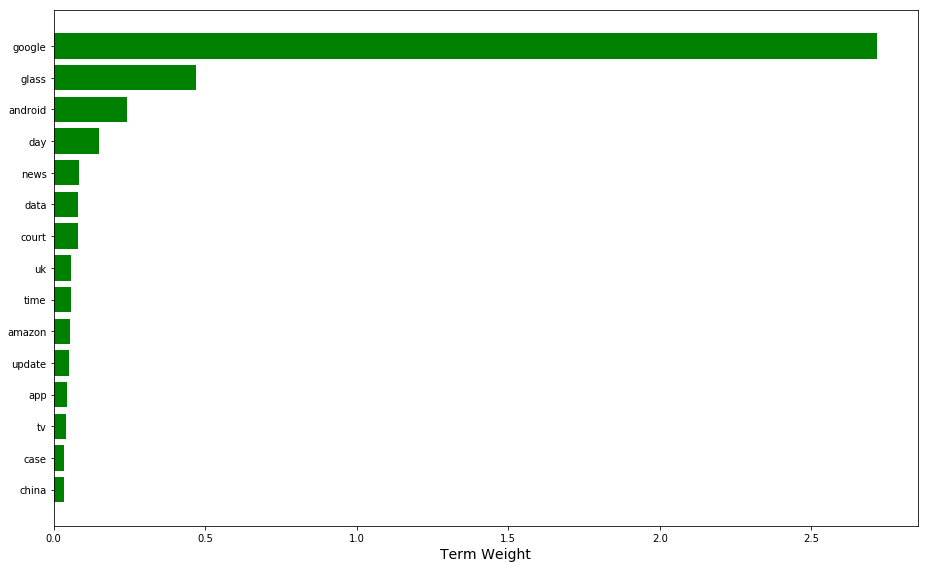

In [77]:
plot_top_term_weights( terms, H, 1, 15 )

A common approach for parameter selection is to Measure and compare the topic coherence of models generated for different values of k.

We need to start by pre-specifying an initial range of "sensible" values

In [78]:
def get_top_snippets( all_snippets, W, topic_index, top ):
    # reverse sort the values to sort the indices
    top_indices = np.argsort( W[:,topic_index] )[::-1]
    # now get the snippets corresponding to the top-ranked indices
    top_snippets = []
    for doc_index in top_indices[0:top]:
        top_snippets.append( all_snippets[doc_index] )
    return top_snippets


In [79]:
kmin, kmax = 2, 8

In [80]:
from sklearn import decomposition
topic_models = []
# try each value of k
for k in range(kmin,kmax+1):
    print("Applying NMF for k=%d ..." % k )
    # run NMF
    model = decomposition.NMF( init="nndsvd", n_components=k ) 
    W = model.fit_transform( A )
    H = model.components_    
    # store for later
    topic_models.append( (k,W,H) )

Applying NMF for k=2 ...
Applying NMF for k=3 ...
Applying NMF for k=4 ...
Applying NMF for k=5 ...
Applying NMF for k=6 ...
Applying NMF for k=7 ...
Applying NMF for k=8 ...


we need to define a class that will generate documents in a form that can be consumed by Gensim's Word2Vec implementation

In [81]:
import re
class TokenGenerator:
    def __init__( self, documents, stopwords ):
        self.documents = documents
        self.stopwords = stopwords
        self.tokenizer = re.compile( r"(?u)\b\w\w+\b" )

    def __iter__( self ):
        print("Building Word2Vec model ...")
        for doc in self.documents:
            tokens = []
            for tok in self.tokenizer.findall( doc ):
                if tok in self.stopwords:
                    tokens.append( "<stopword>" )
                elif len(tok) >= 2:
                    tokens.append( tok )
            yield tokens

Now build a Skipgram Word2Vec model from all documents in the input file using Gensim

In [83]:
import gensim
docgen = TokenGenerator(raw_documents, stop_words )
w2v_model = gensim.models.Word2Vec(docgen, size=500, min_count=20, sg=1)

C:\Users\Christian Conroy\Anaconda3\lib\site-packages\gensim\models\base_any2vec.py:743: UserWarning: C extension not loaded, training will be slow. Install a C compiler and reinstall gensim for fast training.
  "C extension not loaded, training will be slow. "


Building Word2Vec model ...
Building Word2Vec model ...
Building Word2Vec model ...
Building Word2Vec model ...
Building Word2Vec model ...
Building Word2Vec model ...


Once we have our Word2vec model, we can use it as part of our topic coherence approach to evaluate the different NMF topic models that we created previously. To do this, we will implement a simple version of the TC-W2V coherence measure

We use the Word2vec model to calculate coherence scores for each of these models. We will define this coherence score as follows,

In [84]:
def calculate_coherence( w2v_model, term_rankings ):
    overall_coherence = 0.0
    for topic_index in range(len(term_rankings)):
        # check each pair of terms
        pair_scores = []
        for pair in combinations( term_rankings[topic_index], 2 ):
            pair_scores.append( w2v_model.similarity(pair[0], pair[1]))
        # get the mean for all pairs in this topic
        topic_score = sum(pair_scores) / len(pair_scores)
        overall_coherence += topic_score
    # get the mean score across all topics
    return overall_coherence / len(term_rankings)

We also define a function to get the topic descriptor (i.e. list of top terms) for each topic

In [85]:
import numpy as np
def get_descriptor( all_terms, H, topic_index, top ):
    # reverse sort the values to sort the indices
    top_indices = np.argsort( H[topic_index,:] )[::-1]
    # now get the terms corresponding to the top-ranked indices
    top_terms = []
    for term_index in top_indices[0:top]:
        top_terms.append( all_terms[term_index] )
    return top_terms

In [86]:
# process each of the models for different values of k
from itertools import combinations
k_values = []
coherences = []
for (k,W,H) in topic_models:
    # Get all of the topic descriptors - the term_rankings, based on top 10 terms
    term_rankings = []
    for topic_index in range(k):
        term_rankings.append( get_descriptor( terms, H, topic_index, 10 ) )
    # Now calculate the coherence based on our Word2vec model
    k_values.append( k )
    coherences.append( calculate_coherence( w2v_model, term_rankings ) )
    print("K=%02d: Coherence=%.4f" % ( k, coherences[-1] ) )

K=02: Coherence=0.9998
K=03: Coherence=0.9998
K=04: Coherence=0.9998
K=05: Coherence=0.9998
K=06: Coherence=0.9998
K=07: Coherence=0.9998
K=08: Coherence=0.9998


Surprisingly, for this text document, the coherence is all the same for k = 2 to k = 8. Lets plot that & see and note this value and we'll compare it with other techniques.

In [87]:
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
plt.style.use("ggplot")
matplotlib.rcParams.update({"font.size": 14})

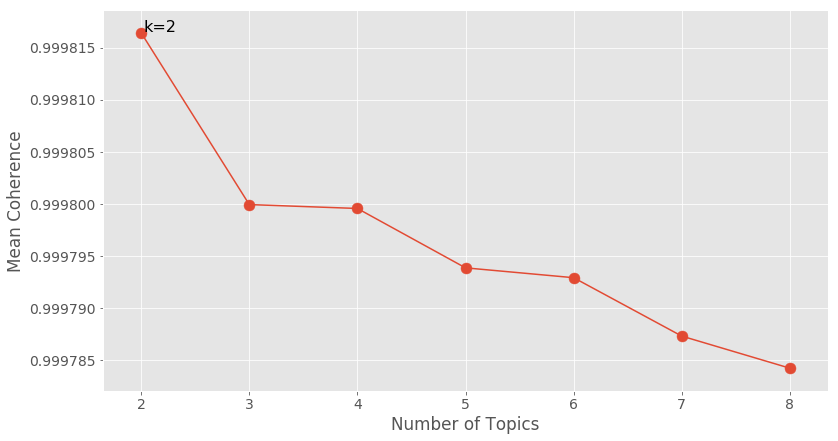

In [88]:
fig = plt.figure(figsize=(13,7))
# create the line plot
ax = plt.plot( k_values, coherences )
plt.xticks(k_values)
plt.xlabel("Number of Topics")
plt.ylabel("Mean Coherence")
# add the points
plt.scatter( k_values, coherences, s=120)
# find and annotate the maximum point on the plot
ymax = max(coherences)
xpos = coherences.index(ymax)
best_k = k_values[xpos]
plt.annotate( "k=%d" % best_k, xy=(best_k, ymax), xytext=(best_k, ymax), textcoords="offset points", fontsize=16)
# show the plot
plt.show()

In [89]:
k = best_k
# get the model that we generated earlier.
W = topic_models[k-kmin][1]
H = topic_models[k-kmin][2]

In [90]:
for topic_index in range(k):
    descriptor = get_descriptor( terms, H, topic_index, 10 )
    str_descriptor = ", ".join( descriptor )
    print("Topic %02d: %s" % ( topic_index+1, str_descriptor ) )

Topic 01: new, apple, says, facebook, study, cases, video, blood, mers, amazon
Topic 02: google, glass, android, day, apple, says, 2014, facebook, news, data


The words under each topic can be seen above and as per the best K value chosen by NMF. We also saw the coherence value of the NMF model. We will compare those results with LDA, LSI and HDP

## Comparing the techniques

In [92]:
# Do models again and get topics 
lsimodel = LsiModel(corpus=corpus, num_topics=5, id2word=id2word)
lsitopics = lsimodel.show_topics(formatted=False)

In [93]:
ldatopics = lda_model.show_topics(formatted=False)

In [94]:
lsitopics = [[word for word, prob in topic] for topicid, topic in lsitopics]

hdptopics = [[word for word, prob in topic] for topicid, topic in hdptopics]

ldatopics = [[word for word, prob in topic] for topicid, topic in ldatopics]

In [95]:
lsi_coherence = CoherenceModel(topics=lsitopics[:10], texts=data_lemmatized, dictionary=id2word, window_size=10).get_coherence()

hdp_coherence = CoherenceModel(topics=hdptopics[:10], texts=data_lemmatized, dictionary=id2word, window_size=10).get_coherence()

lda_coherence = CoherenceModel(topics=ldatopics, texts=data_lemmatized, dictionary=id2word, window_size=10).get_coherence()

# Same data formate for all these. I think we don;t include nnmi because it was a bit more compllicared. 

In [96]:
def evaluate_bar_graph(coherences, indices):
    assert len(coherences) == len(indices)
    n = len(coherences)
    x = np.arange(n)
    plt.figure(figsize=(12,12))
    plt.bar(x, coherences, width=0.2, tick_label=indices, align='center')
    plt.xlabel('Models')
    plt.ylabel('Coherence Value')

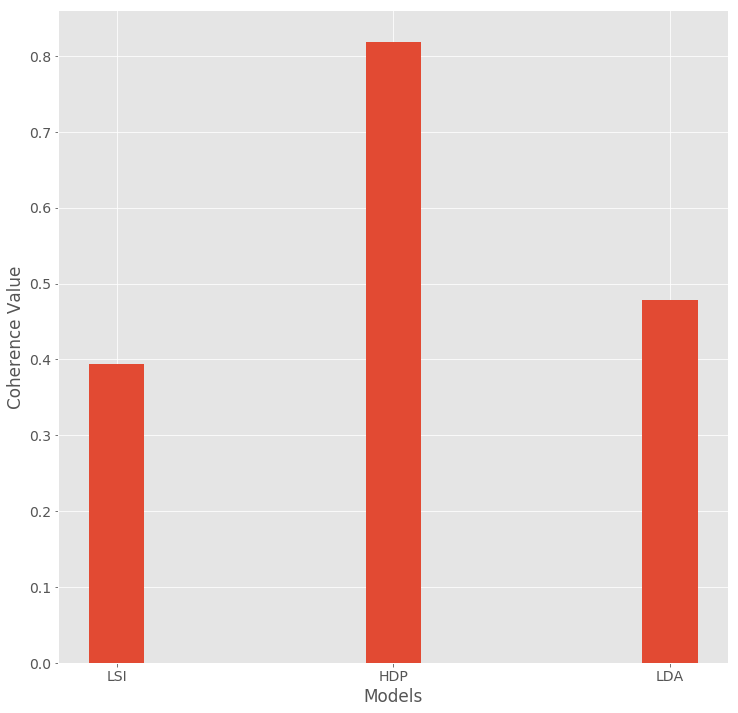

In [97]:
evaluate_bar_graph([lsi_coherence, hdp_coherence, lda_coherence],
                   ['LSI', 'HDP', 'LDA'])

The NMF model has the highest coherence score(not in the plot above -- NMF = .9)